# Survival Process

By Alberto Valdés 

**Mail 1:** anvaldes@uc.cl 

**Mail 2:** alberto.valdes.gonzalez.96@gmail.com

In [1]:
!pip install -q scikit-survival

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import time as time_t
import scipy
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import image as mpimg
from sksurv.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.nonparametric import kaplan_meier_estimator

In [4]:
def display_img(name, a, b):
    plt.figure(figsize = (a, b))
    image = mpimg.imread(name)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [5]:
start_t = time_t.time()

# 1. Read Data

In [6]:
df = pd.read_csv('survival_process.csv')

In [7]:
df.head()

,Age_in_years,Celltype,Karnofsky_score,Months_from_Diagnosis,Prior_therapy,Treatment,Status,Survival_in_days
0,69.0,squamous,60.0,7.0,no,standard,True,72.0
1,64.0,squamous,70.0,5.0,yes,standard,True,411.0
2,38.0,squamous,60.0,3.0,no,standard,True,228.0
3,63.0,squamous,60.0,9.0,yes,standard,True,126.0
4,65.0,squamous,70.0,11.0,yes,standard,True,118.0


**Status:** boolean indicating whether the endpoint has been reached or the event time is right censored.

# 2. Survival Function

$ \hat{S}(t) = \cfrac{number \ of \ patients \ surviving \ beyond \ t}{total \ number \ of \ patients} $

**Kaplan-Meier estimator**

The Kaplan–Meier estimator, also known as the product limit estimator, is a non-parametric statistic used to estimate the survival function from lifetime data.

$ \hat{S}(t) = \prod_{i: t_i \leq t} \left( 1 - \cfrac{d_i}{n_i} \right) $

with $ t_i $ a time when at least one event happened, $ d_i $ the number of events (e.g., deaths) that happened at time $ t_i $, and $ n_i $ the individuals known to have survived (have not yet had an event or been censored) up to time $ t_i $.

In [8]:
df.iloc[[11, 5, 32, 13, 23]][['Status', 'Survival_in_days']]

,Status,Survival_in_days
11,True,8.0
5,True,10.0
32,True,20.0
13,False,25.0
23,True,59.0


Using the formula we can compute $ \hat{S}(t = 11) = \cfrac{3}{5} $, but not $ \hat{S}(t = 30) $ because we don't know whether the 4th patient is still alive at $ t = 30 $, all we know is that when we last checked at $ t = 25 $ the patient was still alive.

In [9]:
time, survival_prob, conf_int = kaplan_meier_estimator(df["Status"], df["Survival_in_days"], conf_type = "log-log")

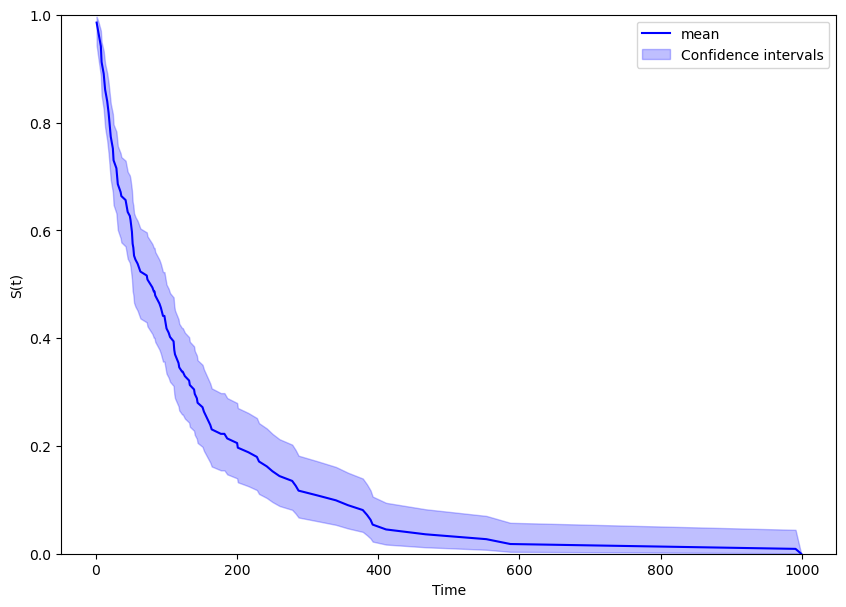

In [10]:
plt.figure(figsize = (10, 7))
plt.plot(time, survival_prob, color = 'blue', label = 'mean')
plt.fill_between(time, conf_int[0], conf_int[1], alpha = 0.25, color = 'blue', label = 'Confidence intervals')
plt.ylim(0, 1)
plt.xlabel('Time')
plt.ylabel('S(t)')
plt.legend()
plt.show()

# 3. Survival function by treatment

In [11]:
df["Treatment"].value_counts()

standard    69
test        68
Name: Treatment, dtype: int64

In [12]:
color_dict = {'standard': 'blue', 'test': 'orangered'}

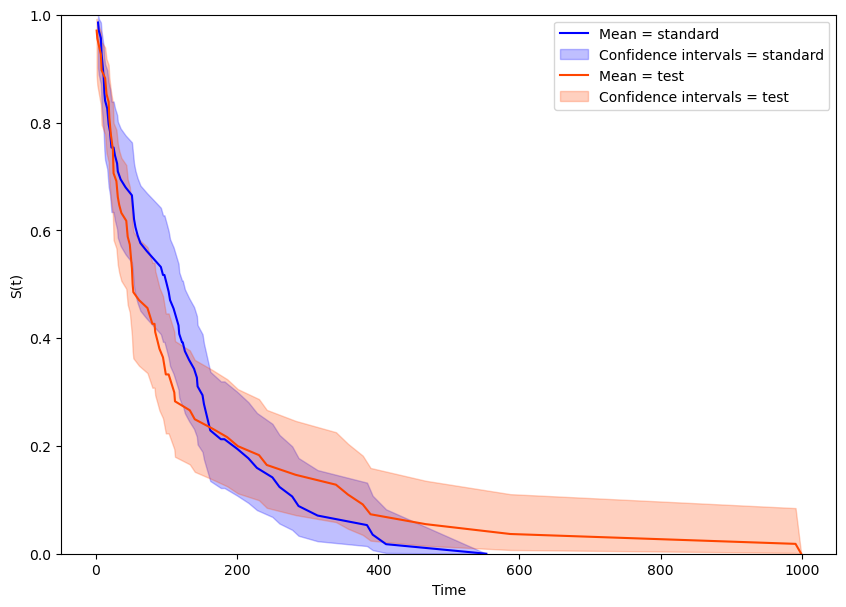

In [13]:
plt.figure(figsize = (10, 7))

for treatment_type in ['standard', 'test']:

    mask_treat = (df['Treatment'] == treatment_type)
    
    time_treat, survival_prob_treat, conf_int_treat = kaplan_meier_estimator(df[mask_treat]["Status"], df[mask_treat]["Survival_in_days"], conf_type = "log-log")
    
    plt.plot(time_treat, survival_prob_treat, color = color_dict[treatment_type], label = f'Mean = {treatment_type}')
    plt.fill_between(time_treat, conf_int_treat[0], conf_int_treat[1], alpha = 0.25, color = color_dict[treatment_type], label = f'Confidence intervals = {treatment_type}')

plt.ylim(0, 1)

plt.xlabel('Time')
plt.ylabel('S(t)')

plt.legend()
plt.show()

# 4. Survival function by celltype

In [14]:
df["Celltype"].value_counts()

smallcell    48
squamous     35
adeno        27
large        27
Name: Celltype, dtype: int64

In [15]:
color_dict = {'smallcell': 'blue', 'squamous': 'orangered', 'adeno': 'green', 'large': 'purple'}

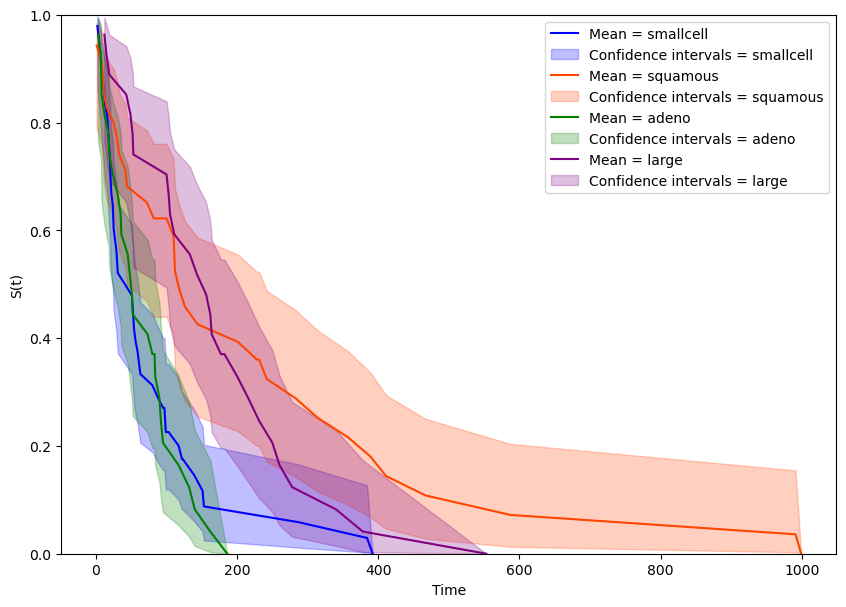

In [16]:
plt.figure(figsize = (10, 7))

for cell_type in ['smallcell', 'squamous', 'adeno', 'large']:
    
    mask_cell = (df['Celltype'] == cell_type)
    
    time_cell, survival_prob_cell, conf_int_cell = kaplan_meier_estimator(df[mask_cell]["Status"], df[mask_cell]["Survival_in_days"], conf_type = "log-log")
    
    plt.plot(time_cell, survival_prob_cell, color = color_dict[cell_type], label = f'Mean = {cell_type}')
    plt.fill_between(time_cell, conf_int_cell[0], conf_int_cell[1], alpha = 0.25, color = color_dict[cell_type], label = f'Confidence intervals = {cell_type}')

plt.ylim(0, 1)

plt.xlabel('Time')
plt.ylabel('S(t)')

plt.legend()
plt.show()

# 5. Multivariate survival models

### i. Encoding

In [17]:
cat_cols = ['Celltype', 'Prior_therapy', 'Treatment']
df[cat_cols] = df[cat_cols].astype('category')
oh_enc = OneHotEncoder()
oh_enc = oh_enc.fit(df[cat_cols])
new_cat_cols = oh_enc.transform(df[cat_cols]).copy()
df = pd.concat([df, new_cat_cols], axis = 1)
df = df.drop(columns = cat_cols)

In [18]:
df.head()

,Age_in_years,Karnofsky_score,Months_from_Diagnosis,Status,Survival_in_days,Celltype=large,Celltype=smallcell,Celltype=squamous,Prior_therapy=yes,Treatment=test
0,69.0,60.0,7.0,True,72.0,0.0,0.0,1.0,0.0,0.0
1,64.0,70.0,5.0,True,411.0,0.0,0.0,1.0,1.0,0.0
2,38.0,60.0,3.0,True,228.0,0.0,0.0,1.0,0.0,0.0
3,63.0,60.0,9.0,True,126.0,0.0,0.0,1.0,1.0,0.0
4,65.0,70.0,11.0,True,118.0,0.0,0.0,1.0,1.0,0.0


In [19]:
y_cols = ['Status', 'Survival_in_days']

In [20]:
X_cols = list(df.columns)

In [21]:
for y_c in y_cols:
    X_cols.remove(y_c)

### ii. Train model

In [22]:
estimator = CoxPHSurvivalAnalysis()

In [23]:
estimator = estimator.fit(df[X_cols], df[y_cols].to_records(index = False))

# 6. Measuring the performance

In [24]:
prediction = estimator.predict(df[X_cols])

**Concordance Index:**

Concordance intuitively means that two samples were ordered correctly by the model. More specifically, two samples are concordant, if the one with a higher estimated risk score has a shorter actual survival time. When predicted risks are identical for a pair, 0.5 rather than 1 is added to the count of concordant pairs.

In [25]:
round(estimator.score(df[X_cols], df[y_cols].to_records(index = False))*100, 2)

73.63

# 7. Feature Selection

In [26]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j : j + 1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

In [27]:
scores = fit_and_score_features(df[X_cols].values, df[y_cols].to_records(index = False))

In [28]:
scores_df = pd.DataFrame(zip(scores, np.array(X_cols))).rename(columns = {0: 'score', 1: 'variable'})
scores_df = scores_df.sort_values(by = ['score'], ascending = False)

In [29]:
scores_df

,score,variable
1,0.709280,Karnofsky_score
4,0.572581,Celltype=smallcell
3,0.561620,Celltype=large
5,0.550545,Celltype=squamous
7,0.525386,Treatment=test
0,0.515107,Age_in_years
2,0.509030,Months_from_Diagnosis
6,0.494434,Prior_therapy=yes


We going to select:

* Karnofsky_score
* Celltype=smallcell
* Celltype=large
* Celltype=squamous

# 8. GridSearch

In [30]:
X_cols = ['Karnofsky_score', 'Celltype=smallcell', 'Celltype=large', 'Celltype=squamous']

In [31]:
model = CoxPHSurvivalAnalysis()

In [32]:
N_alpha = 20

In [33]:
params = {'alpha': [i for i in range(N_alpha)]}

In [34]:
clf = GridSearchCV(model, params, cv = 3, n_jobs = 4)

In [35]:
clf = clf.fit(df[X_cols].values, df[y_cols].to_records(index = False))

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [36]:
report = pd.DataFrame.from_dict(clf.cv_results_)

In [37]:
report = report[['param_alpha', 'mean_test_score']]

In [38]:
report = report.sort_values(by = ['mean_test_score'], ascending = False)

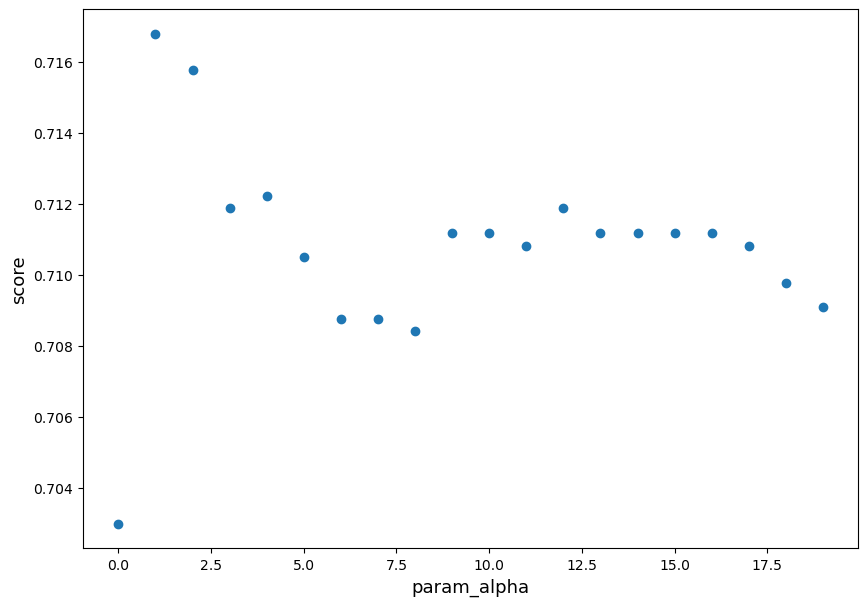

In [39]:
plt.figure(figsize = (10, 7))
plt.scatter(report['param_alpha'], report['mean_test_score'])
plt.xlabel('param_alpha', fontsize = 13)
plt.ylabel('score', fontsize = 13)
plt.show()

# 9. Train definitive model

In [40]:
model = CoxPHSurvivalAnalysis(alpha = 10)

In [41]:
model = model.fit(df[X_cols], df[y_cols].to_records(index = False))

# 10. Predict survival functions

In [42]:
time_points = np.arange(1, 1000)

In [43]:
prediction = model.predict_survival_function(df[X_cols])

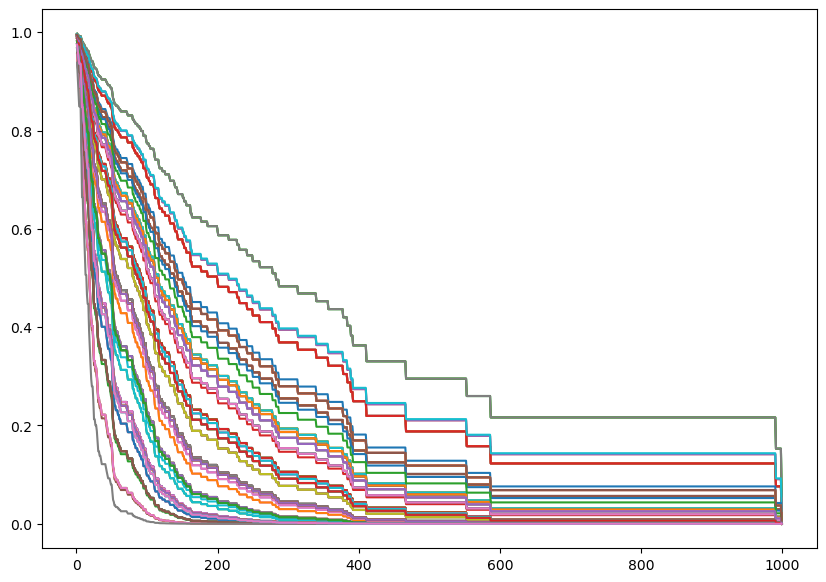

In [44]:
plt.figure(figsize = (10, 7))

for i, surv_func in enumerate(prediction):
    plt.plot(time_points, surv_func(time_points))

plt.show()

### Time of execution

In [45]:
end_t = time_t.time()

In [46]:
delta = (end_t - start_t)

hours = int(delta/3600)
mins = int((delta - hours*3600)/60)
segs = int(delta - hours*3600 - mins*60)
print(f'Execute this notebook take us {hours} hours, {mins} minutes and {segs} seconds.')

Execute this notebook take us 0 hours, 0 minutes and 2 seconds.
